## **0. [Predict Future Sales - Kaggle Competition](https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data)**

*Informacje z Kaggle:* 

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## 1. **Dane**
Zbiór danych składa się z 6 plików CSV: 
- sales_train.csv : dane historyczne sprzedazy produktów
- shops.csv: sklepy z nazwami
- item_categories.csv : kategorie produktów
- items.csv : produkty z nazwą, ID i ID kategorii
- test.csv : zbiór testowy na którym będzie sprawdzana skuteczność w Kaggle. Zawiera jedynie ID sklepu i produktu.
- sample_submission.csv : plik przedstawiający jak powinien wyglądać plik z predykcjami wrzucany do Kaggle.

In [3]:
"""
- dane w przedziale 2013-01-01 do 2015-10-31
- kolumna date_block_num - numer miesiąca w calym zbiorze (od 0 do 33)
- kolumna shop_id - unikalny identyfikator sklepu
- kolumna item_id - unikalny identyfikator produktu
- kolumna item_price - cena produktu, nieznormalizowana
- kolumna item_cnt_day - liczba sprzedanych produktów. Tą wartość będziemy przewidywać.
"""
pd.read_csv(".data/base/sales_train.csv")

date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...               ...  
2935844           1.0  
2935845           1.0  
2935846           1.0  
2935847           1.0  
2935848           1.0  

[2935849 rows x 6 columns]

In [4]:
"""
- kolumna shop_name - nazwa produktu, cyrylica, j. rosyjski
"""
pd.read_csv(".data/base/shops.csv").sample(5)

shop_name  shop_id
7                  Воронеж ТРЦ "Максимир"        7
20                    Москва "Распродажа"       20
37                  Новосибирск ТЦ "Мега"       37
39  РостовНаДону ТРК "Мегацентр Горизонт"       39
14                Казань ТЦ "ПаркХаус" II       14

In [5]:
"""
- item_category_name - nazwa kategorii produktu, cyrylica, j. rosyjski
- niektore kategorie mogą wskazywać podobieństwo, np. PS2, PS3, PS4. Warto przetlumaczyc
"""
pd.read_csv(".data/base/item_categories.csv")

item_category_name  item_category_id
0     PC - Гарнитуры/Наушники                 0
1            Аксессуары - PS2                 1
2            Аксессуары - PS3                 2
3            Аксессуары - PS4                 3
4            Аксессуары - PSP                 4
..                        ...               ...
79                  Служебные                79
80         Служебные - Билеты                80
81    Чистые носители (шпиль)                81
82  Чистые носители (штучные)                82
83           Элементы питания                83

[84 rows x 2 columns]

In [6]:
"""
- item_name - nazwa produktu, cyrylica, j. rosyjski
"""
pd.read_csv(".data/base/items.csv")

item_name  item_id  \
0              ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      !ABBYY FineReader 12 Professional Edition Full...        1   
2          ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3        ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4            ***КОРОБКА (СТЕКЛО)                       D        4   
...                                                  ...      ...   
22165             Ядерный титбит 2 [PC, Цифровая версия]    22165   
22166    Язык запросов 1С:Предприятия  [Цифровая версия]    22166   
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id  
0                    40  
1                    76  
2                    40  
3                    40  
4                    40  
...                 ...  
22165                31  
22166                54  
22167                49  
22168                62  
22169                69  

[22170 rows x 3 columns]

In [7]:
"""
- kolumna ID - identyfikator pary (sklep, produkt)
- Z Kaggle wiemy, że ten zbiór odnosi się do okresu 2015-11-01 do 2015-11-30, zatem bylby to date_block_num=34
- Inferencja odbywa się jedynie dla zadanego sklepu i produktu, nie posiadamy zadnej dodatkowej informacji, musimy je wywnioskować z danych treningowych
"""
pd.read_csv(".data/base/test.csv")

ID  shop_id  item_id
0            0        5     5037
1            1        5     5320
2            2        5     5233
3            3        5     5232
4            4        5     5268
...        ...      ...      ...
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969

[214200 rows x 3 columns]

In [8]:
pd.read_csv(".data/base/sample_submission.csv")

ID  item_cnt_month
0            0             0.5
1            1             0.5
2            2             0.5
3            3             0.5
4            4             0.5
...        ...             ...
214195  214195             0.5
214196  214196             0.5
214197  214197             0.5
214198  214198             0.5
214199  214199             0.5

[214200 rows x 2 columns]

In [9]:
df = pd.read_parquet(".data/data.parquet")

In [10]:
print(f"""
Statystyki liczności zbiorów zmiennych kategorycznych:
    - unique_shops: {df['shop_id'].nunique()}
    - unique_items: {df['item_id'].nunique()}
    - unique_categories: {df['item_category_id'].nunique()}
""")


Statystyki liczności zbiorów zmiennych kategorycznych:
    - unique_shops: 60
    - unique_items: 22170
    - unique_categories: 84



In [11]:
"""
W zbiorze nie występują dane brakujące, kazda kolumna ma prawidłowe wartości.
Wartości NaN w kolumnach `date`, `item_price` i `item_cnt_day` wynikają z dodania do zbioru danych z ostatniego (testowego) miesiąca.
"""
df.isna().sum()

date                           214200
date_block_num                      0
shop_id                             0
item_id                             0
item_price                     214200
item_cnt_day                   214200
date_month                          0
shop_name                           0
shop_name_en                        0
city                                0
shop_name_direct                    0
city_id                             0
item_name                           0
item_category_id                    0
item_category_name                  0
item_category_name_en               0
general_item_category_name          0
specific_item_category_name         0
general_item_category_id            0
dtype: int64

In [12]:
df.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    3.150049e+06  3.150049e+06  3.150049e+06  2.935849e+06  2.935849e+06   
mean     1.589114e+01  3.290933e+01  1.025313e+04  8.908532e+02  1.242641e+00   
std      1.032864e+01  1.632479e+01  6.322838e+03  1.729800e+03  2.618834e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01   
25%      7.000000e+00  2.200000e+01  4.510000e+03  2.490000e+02  1.000000e+00   
50%      1.500000e+01  3.100000e+01  9.461000e+03  3.990000e+02  1.000000e+00   
75%      2.400000e+01  4.700000e+01  1.572700e+04  9.990000e+02  1.000000e+00   
max      3.400000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03   

         date_month       city_id  item_category_id  general_item_category_id  
count  3.150049e+06  3.150049e+06      3.150049e+06              3.150049e+06  
mean   5.570867e+00  1.506304e+01      4.043034e+01              9.961043e+00  
std    3.617431e+00  7.861710e+00      1.714860e+01              3.491220e+00  
min    0.000000e+00  0.000000e+00      0.000000e+00              0.000000e+00  
25%    2.000000e+00  1.200000e+01      2.900000e+01              8.000000e+00  
50%    6.000000e+00  1.400000e+01      4.000000e+01              1.100000e+01  
75%    9.000000e+00  2.100000e+01      5.500000e+01              1.300000e+01  
max    1.100000e+01  3.000000e+01      8.300000e+01              1.900000e+01

In [14]:
"""
- Wszystkie kolumny kategoryczne/porządkowe (date_block_num, date_month, shop_id, item_id, item_category_id, general_item_category_id)
mają typ int64, co jest zgodne z oczekiwaniami, nie występują wartości niezgodne z typem.
- Kolumny tesktowe (shop_name, shop_name_en, shop_name_direct, city, item_name, item_category_name, item_category_name_en, 
general_item_category_name, specific_item_category_name) mają typ object, co również jest zgodne z oczekiwaniami.
- Zmienne numeryczne (item_price, item_cnt_day) mają typ float64, typ się zgadza.
- Kolumna date była poprawnie zrzutowana z uzyciem `pd.to_datetime` na typ datetime64[ns], nie ma błędów.

Wniosek: dane są poprawne, nie jest potrzebna konwersja typów oraz sprawdzanie, czy dane nie mają błędów w zapisie.
"""
df.dtypes

date                            object
date_block_num                   int64
shop_id                          int64
item_id                          int64
item_price                     float64
item_cnt_day                   float64
date_month                       int64
shop_name                       object
shop_name_en                    object
city                            object
shop_name_direct                object
city_id                          int64
item_name                       object
item_category_id                 int64
item_category_name              object
item_category_name_en           object
general_item_category_name      object
specific_item_category_name     object
general_item_category_id         int64
dtype: object

## 2.1 **Analiza wartości odstających**

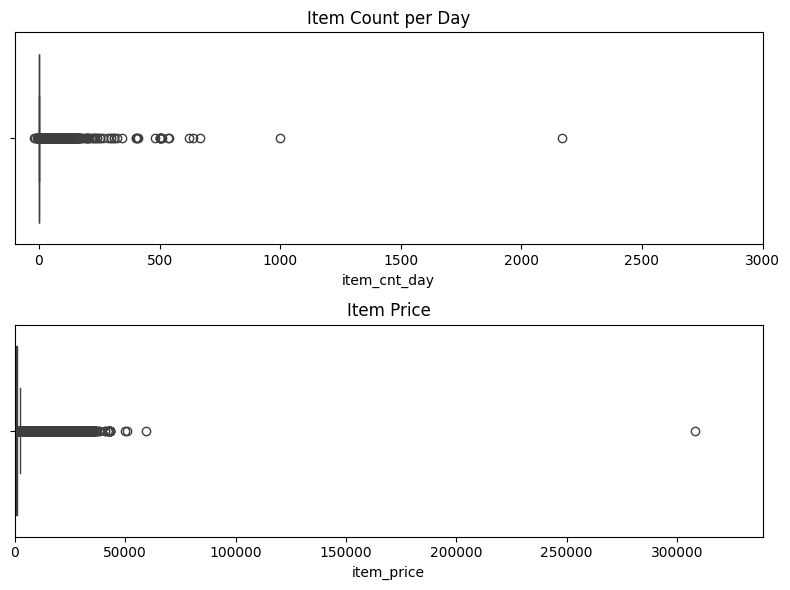

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# First plot
axes[0].set_xlim(-100, 3000)
sns.boxplot(x=df.item_cnt_day, ax=axes[0])
axes[0].set_title('Item Count per Day')

# Second plot
axes[1].set_xlim(df.item_price.min(), df.item_price.max() * 1.1)
sns.boxplot(x=df.item_price, ax=axes[1])
axes[1].set_title('Item Price')

# Save the figure
plt.tight_layout()
plt.savefig('assets/plots/bot_plot.png')
plt.show()

In [29]:
outliers_item_price_index = df['item_price'] > 100000
outliers_item_cnt_day_index = df['item_cnt_day'] > 1000

print(f'Przed odfiltrowaniem `item_price`: \n{df["item_price"].describe()} \nPo odfiltrowaniu: \n{df[~outliers_item_price_index]["item_price"].describe()}')
print(f'\n\nPrzed odfiltrowaniem `item_cnt_day`: \n{df["item_cnt_day"].describe()} \nPo odfiltrowaniu: \n{df[~outliers_item_cnt_day_index]["item_cnt_day"].describe()}')

Przed odfiltrowaniem `item_price`: 
count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64 
Po odfiltrowaniu: 
count    2.935848e+06
mean     8.907486e+02
std      1.720490e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      5.920000e+04
Name: item_price, dtype: float64


Przed odfiltrowaniem `item_cnt_day`: 
count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64 
Po odfiltrowaniu: 
count    2.935848e+06
mean     1.241903e+00
std      2.292962e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+03
Name: item_cnt_day, dtype: float64


Z (jednostronnych) box plotów widac wartosci odstajace dla `item_cnt_day` (~ >1000) oraz `item_price` (~ >60000). 
Wartosci te zostana odfiltrowane w fazie budowania cech.

In [16]:
df[df.item_price <= 0]

date  date_block_num  shop_id  item_id  item_price  \
1645106  15.05.2013               4       32     2973        -1.0   

         item_cnt_day  date_month                   shop_name  \
1645106           1.0           4  Москва ТЦ "Серебряный Дом"   

                     shop_name_en    city   shop_name_direct  city_id  \
1645106  Moscow Silver House Mall  Moscow  Silver House Mall       14   

                                         item_name  item_category_id  \
1645106  DmC Devil May Cry [PS3, русские субтитры]                19   

        item_category_name item_category_name_en general_item_category_name  \
1645106         Игры - PS3           Games - PS3                      Games   

        specific_item_category_name  general_item_category_id  
1645106                         PS3                         5

Istnieje jeden rekord z ceną równą -1. Nalezy go usunąć, lub imputowac dowolna technika (np. mean, median itp.)

In [ ]:
df.loc[df.shop_id.isin([0, 57]), ['shop_id', 'shop_name', 'shop_name_en']].apply(pd.Series.unique)

In [ ]:
df.loc[df.shop_id.isin([1, 58]), ['shop_id', 'shop_name', 'shop_name_en']].apply(pd.Series.unique)

In [ ]:
df.loc[df.shop_id.isin([10, 11]), ['shop_id', 'shop_name', 'shop_name_en']].apply(pd.Series.unique)

Nastepujace pary sklepów są najprawdpodobniej tymi samymi sklepami o rownych identyfikatorach. 
Kazdy z nich zostanie przypisany do jednej wartosci z pary.
- `(0, 57)`
- `(1, 58)`
- `(10, 11)`

In [ ]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## 2.2 **Analiza cech**
Kazda cecha zostanie przeanalizowana pod kątem wskazania jej cech. Dla zmiennych kategorycznych wskazane będą liczność wraz z wykresami. Dla zmiennych numerycznych wskazane będą ich rozkłady.

In [30]:
def categorical_analysis(df, column):
    """
    Funkcja zwraca statystyki dla kolumny kategorycznej
    """
    vc = df[column].value_counts()
    vc_norm = vc / vc.sum()
    return pd.DataFrame({'count': vc, 'norm_count': vc_norm})

def categorical_plot(df_analysis, column):
    """
    Funkcja rysuje wykres słupkowy dla analizy kategorycznej
    """
    plt.figure(figsize=(12, 5))
    plt.bar(df_analysis.index, df_analysis['count'])
    plt.title(f'Bar frequency plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

count  norm_count
shop_id                    
31       240736    0.076423
25       191204    0.060699
28       147334    0.046772
54       143480    0.045548
57       122528    0.038897
42       114353    0.036302
27       105366    0.033449
6         87763    0.027861
58        76541    0.024298
56        74673    0.023705
46        71421    0.022673
50        70273    0.022309
19        69011    0.021908
15        64611    0.020511
35        63545    0.020173
21        63233    0.020074
7         63176    0.020056
47        61795    0.019617
26        59010    0.018733
18        58327    0.018516
24        58132    0.018454
53        58021    0.018419
16        57834    0.018360
38        51113    0.016226
30        50860    0.016146
22        50534    0.016042
29        49225    0.015627
52        48602    0.015429
59        47208    0.014986
41        47067    0.014942
37        44738    0.014202
44        44630    0.014168
51        44433    0.014105
4         43342    0.013759
5         43279    0.013739
14        42079    0.013358
45        40991    0.013013
55        39869    0.012657
12        39794    0.012633
43        39282    0.012470
2         31091    0.009870
3         30632    0.009724
48        26712    0.008480
10        26497    0.008412
17        22950    0.007286
49        20949    0.006650
39        18540    0.005886
13        17824    0.005658
34        10852    0.003445
0          9857    0.003129
32         7947    0.002523
23         6963    0.002210
1          5678    0.001803
36         5406    0.001716
33         5027    0.001596
40         4257    0.001351
9          3751    0.001191
8          3412    0.001083
20         1792    0.000569
11          499    0.000158

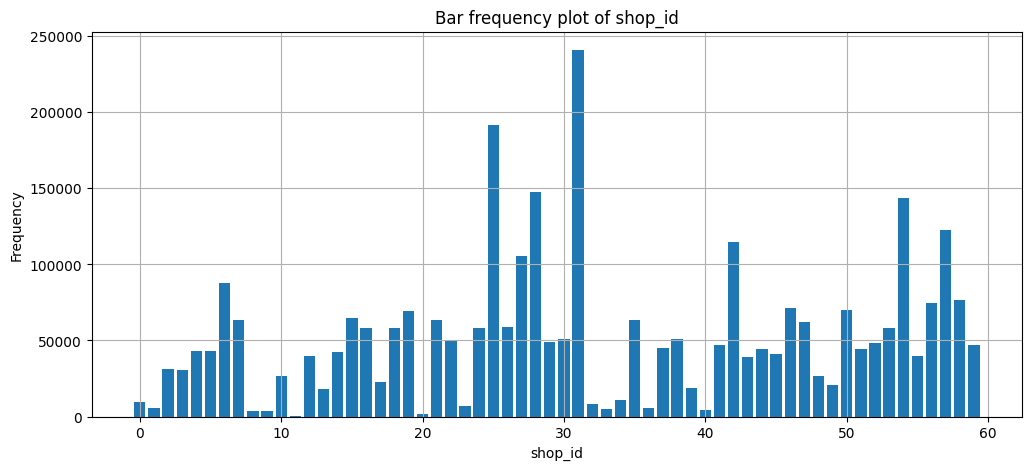

In [32]:
categorical_analysis_shop_id = categorical_analysis(df, 'shop_id')
display(categorical_analysis_shop_id)
categorical_plot(categorical_analysis_shop_id, 'shop_id')

count    norm_count
item_id                     
20949    31382  9.962385e-03
5822      9450  2.999953e-03
17717     9109  2.891701e-03
2808      7521  2.387582e-03
4181      6895  2.188855e-03
...        ...           ...
5606         1  3.174554e-07
5732         1  3.174554e-07
5924         1  3.174554e-07
6925         1  3.174554e-07
14843        1  3.174554e-07

[22170 rows x 2 columns]

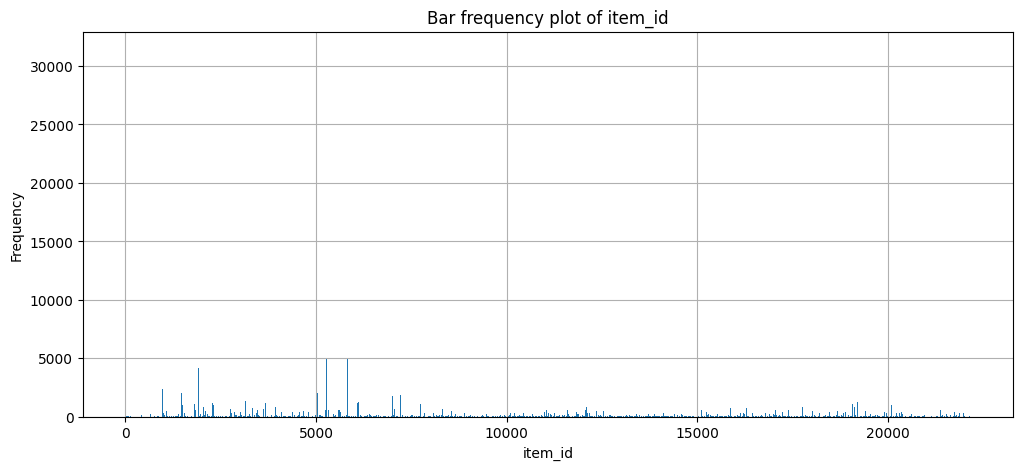

In [33]:
categorical_analysis_item_id = categorical_analysis(df, 'item_id')
display(categorical_analysis_item_id)
categorical_plot(categorical_analysis_item_id, 'item_id')

count    norm_count
item_category_id                      
40                596992  1.895183e-01
55                367809  1.167629e-01
30                357303  1.134278e-01
19                214099  6.796688e-02
37                206576  6.557866e-02
...                  ...           ...
52                     3  9.523661e-07
1                      2  6.349108e-07
50                     2  6.349108e-07
10                     1  3.174554e-07
51                     1  3.174554e-07

[84 rows x 2 columns]

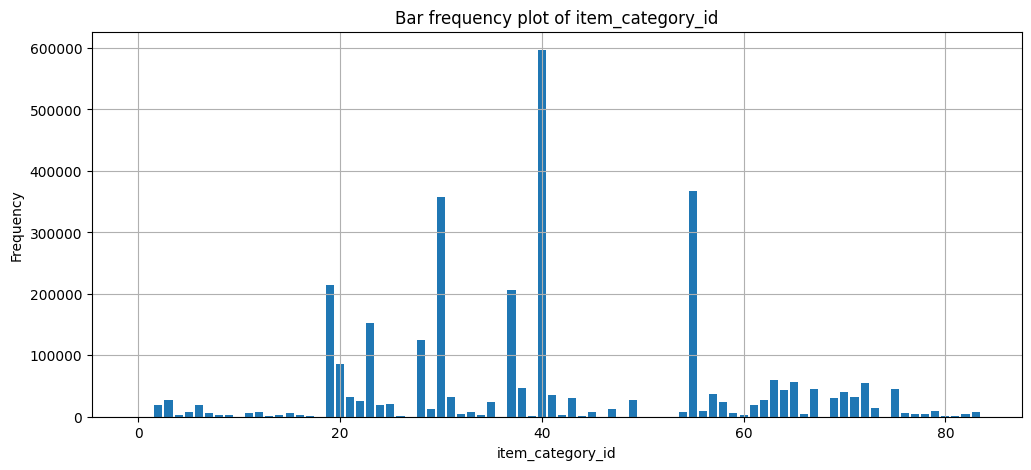

In [34]:
categorical_analysis_item_category_id = categorical_analysis(df, 'item_category_id')
display(categorical_analysis_item_category_id)
categorical_plot(categorical_analysis_item_category_id, 'item_category_id')

count  norm_count
date_block_num                    
34              214200    0.067999
11              143246    0.045474
23              130786    0.041519
2               121347    0.038522
0               115690    0.036726
1               108613    0.034480
7               104772    0.033260
6               100548    0.031920
5               100403    0.031873
12               99349    0.031539
10               96736    0.030709
8                96137    0.030519
9                94202    0.029905
3                94109    0.029875
14               92733    0.029439
4                91759    0.029129
13               89830    0.028517
24               88522    0.028102
19               86614    0.027496
22               86428    0.027437
17               82408    0.026161
21               79361    0.025194
18               78760    0.025003
16               78529    0.024929
15               77906    0.024732
20               73157    0.023224
25               71808    0.022796
26               69977    0.022215
31               57029    0.018104
27               56274    0.017864
30               55549    0.017634
29               54617    0.017338
28               54548    0.017317
33               53514    0.016988
32               50588    0.016059

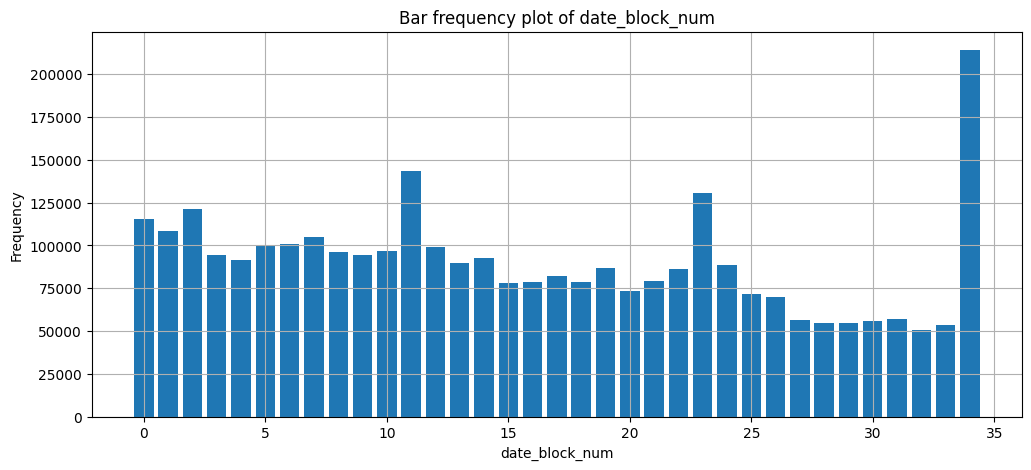

In [35]:
categorical_analysis_date_block_num = categorical_analysis(df, 'date_block_num')
display(categorical_analysis_date_block_num)
categorical_plot(categorical_analysis_date_block_num, 'date_block_num')

In [36]:
def numerical_analysis(df, column):
    """
    Funkcja zwraca statystyki dla kolumny kategorycznej
    """
    vc = df[column].value_counts()
    vc_norm = vc / vc.sum()
    return pd.DataFrame({'count': vc, 'norm_count': vc_norm})

def numerical_plot(df_analysis, column, bins=None):
    """
    Funkcja rysuje wykres słupkowy dla analizy kategorycznej
    """
    plt.figure(figsize=(12, 5))
    plt.hist(df_analysis[column], bins=bins)
    plt.title(f'Hist plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

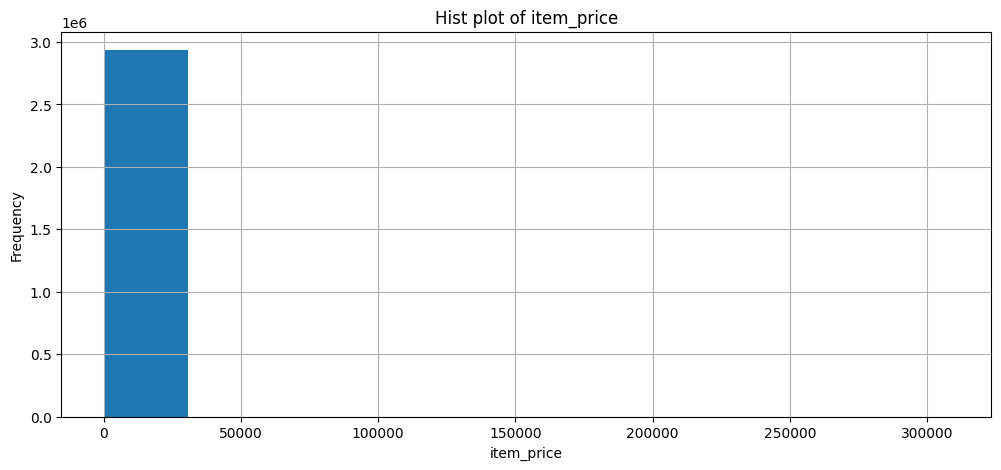

In [37]:
numerical_plot(df, 'item_price')

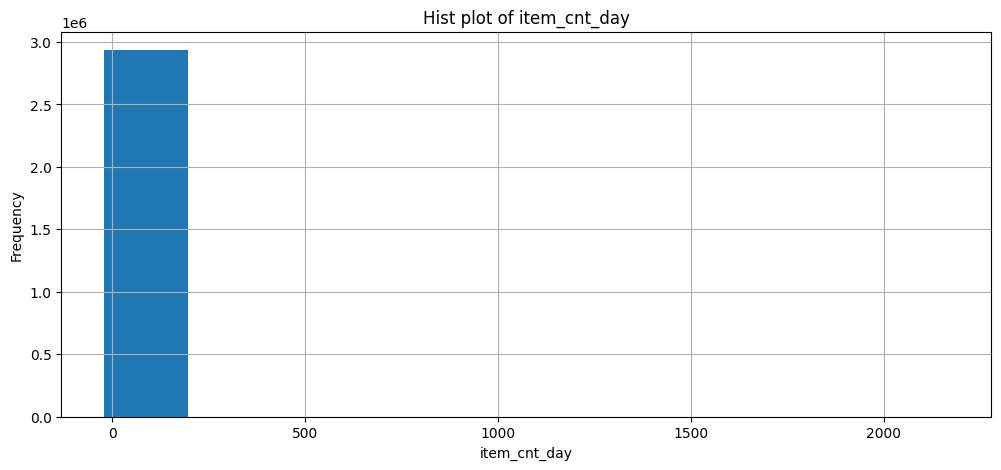

In [40]:
numerical_plot(df, 'item_cnt_day')

## 3. **Zaawansowana Analiza cech**


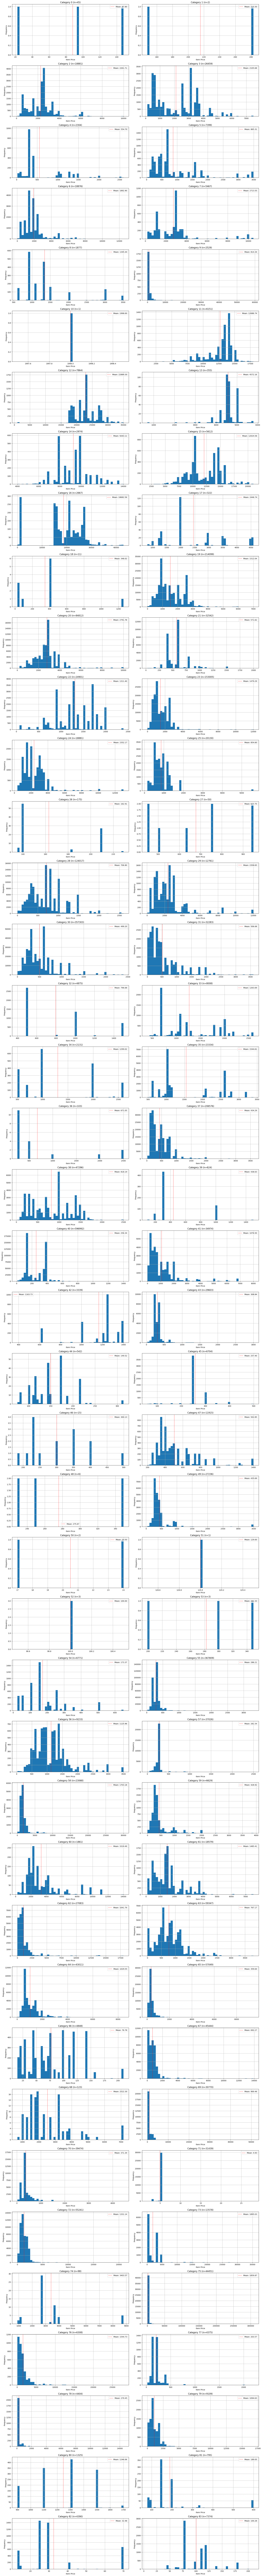

In [45]:
"""
Histogramy średniej ceny artykułów w kazdej kategorii wskazują (wizualnie)
na silne powiazanie tych dwoch atrybutow. Średnia cena artykułu w danej
kategorii moze byc potencjalną cechą otrzymaną w procesie inzynierii
cech.
"""

unique_categories = np.sort(df['item_category_id'].unique())

plt.figure(figsize=(20, 200))
for i, category in enumerate(unique_categories, 1):
    plt.subplot(len(unique_categories) // 2 + 1, 2, i)
    category_data = df[df['item_category_id'] == category]['item_price']
    category_data.hist(bins=50)
    mean_price = category_data.mean()
    plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_price:.2f}')
    plt.title(f'Category {category} (n={len(category_data)})')
    plt.xlabel('Item Price')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

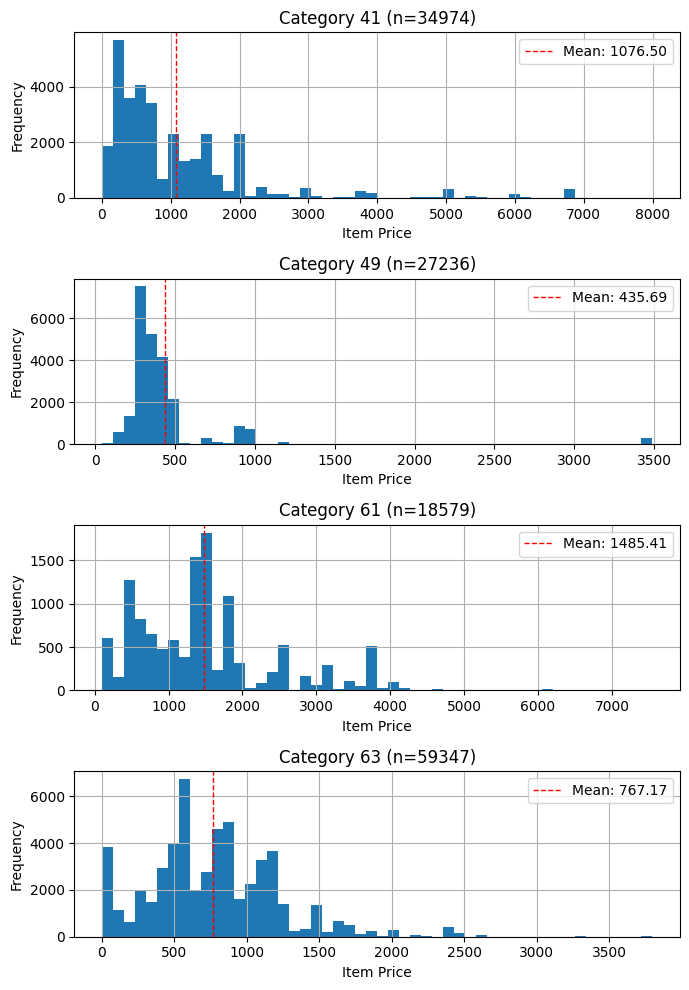

In [60]:
unique_categories = [41, 49, 61, 63]

fig = plt.figure(figsize=(7, 10))
for i, category in enumerate(unique_categories, 1):
    plt.subplot(len(unique_categories), 1, i)
    category_data = df[df['item_category_id'] == category]['item_price']
    category_data.hist(bins=50)
    mean_price = category_data.mean()
    plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_price:.2f}')
    plt.title(f'Category {category} (n={len(category_data)})')
    plt.xlabel('Item Price')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('assets/plots/category_price_hist.png')

<Figure size 2000x800 with 0 Axes>

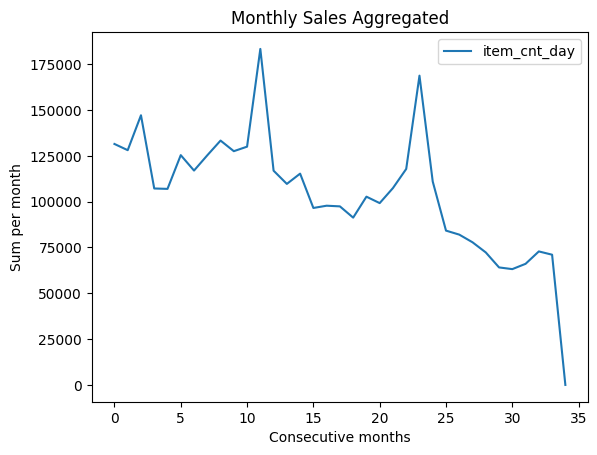

In [65]:
"""
Miesięczna suma sprzedazy we wszystkich sklepach spada zgodnie z jakims trendem.
Osiaga piki, najprawdopodobniej co określony interwał czasowy. Być moze miesiac
w ktorym przypada zbior testowy rowniez bedzie posiadal taki pik. Nalezy na to
zwrocic uwage.
"""

plt.figure(figsize=(20, 8))
monthly_sales_aggregated = df.groupby("date_block_num").agg({"item_cnt_day": "sum"})
monthly_sales_aggregated.plot()
plt.title('Monthly Sales Aggregated')
plt.xlabel('Consecutive months')
plt.ylabel('Sum per month')
plt.legend()


In [71]:
df.groupby(["shop_id", "date_block_num"]).agg({"item_cnt_day": "sum"}).unstack().to_numpy()

array([[5578., 6127.,   nan, ...,   nan,   nan,   nan],
       [2947., 3364.,   nan, ...,   nan,   nan,   nan],
       [1146.,  488.,  753., ...,  822.,  727.,    0.],
       ...,
       [  nan,   nan, 6586., ..., 2266., 2316.,    0.],
       [  nan,   nan, 3773., ..., 1319., 1446.,    0.],
       [2017., 1897., 2028., ...,  914.,  790.,    0.]])

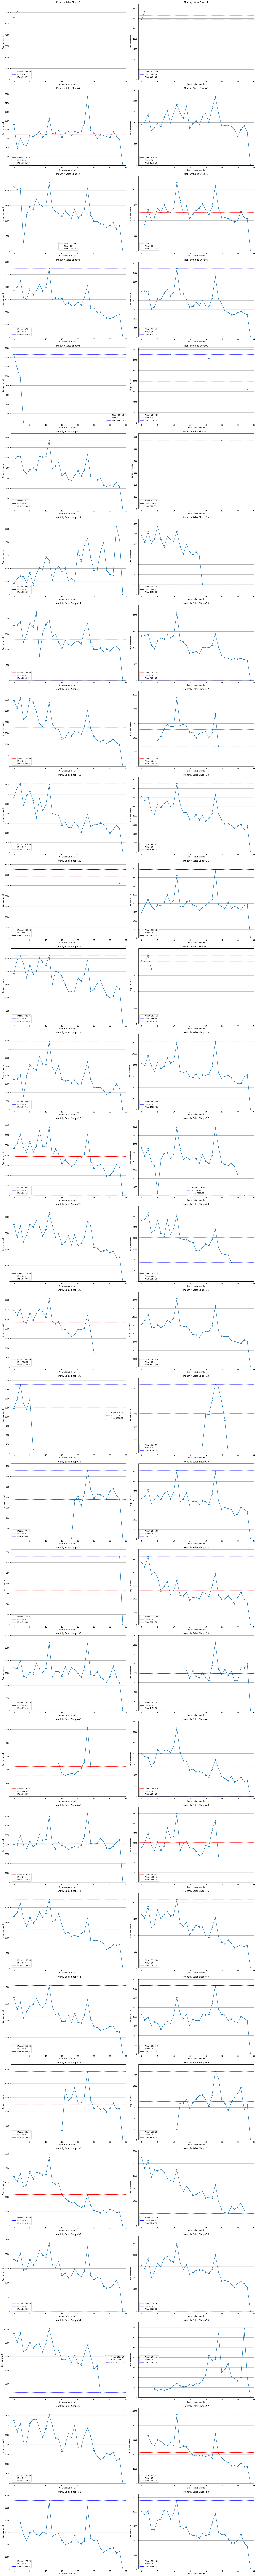

In [72]:
"""
Nie wszystkie sklepy są notowane kazdego miesiąca, jest to problem, ktory będzie musiał
zostać rozwiązany podczas przewidywania, poniewaz przy podziale datasetu na treningowy/
walidacyjny/testowy będziemy uzywac odcięcia czasowego, tj. dane z wczesniejszych miesiecy
beda uzywane do trenowania modelu uzywanego do pozniejszych miesiecy. Jesli sklep nie pojawi
sie w poprzednich miesiacach, a będzie w zbiorze do predykcji to będziemy musieli wnioskowac
na bazie innych sklepów i artykułów.
"""

monthly_sales_per_shop = df.groupby(["shop_id", "date_block_num"]).agg({"item_cnt_day": "sum"})
monthly_sales_per_shop_matrix = monthly_sales_per_shop.unstack().to_numpy()

fig, ax = plt.subplots(monthly_sales_per_shop_matrix.shape[0] // 2, 2, figsize=(20, 200))
for i in range(monthly_sales_per_shop_matrix.shape[0]):
    m, n = (i // 2), (i % 2)
    ax[m, n].plot(monthly_sales_per_shop_matrix[i], marker='o')
    ax[m, n].axhline(np.nanmean(monthly_sales_per_shop_matrix[i]), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.nanmean(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[m, n].axhline(np.nanmin(monthly_sales_per_shop_matrix[i]), color='blue', linestyle='dashed', linewidth=1, label=f'Min: {np.nanmin(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[m, n].axhline(np.nanmax(monthly_sales_per_shop_matrix[i]), color='blue', linestyle='dashed', linewidth=1, label=f'Max: {np.nanmax(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[m, n].set_xlim(-1, 35)
    ax[m, n].set_ylim(min(0, np.nanmin(monthly_sales_per_shop_matrix[i])), 1.1 * np.nanmax(monthly_sales_per_shop_matrix[i]))
    ax[m, n].grid(True)
    ax[m, n].set_title(f'Monthly Sales Shop={i}')
    ax[m, n].set_xlabel('Consecutive months')
    ax[m, n].set_ylabel('Sum per month')
    ax[m, n].legend()

plt.tight_layout()
plt.show()

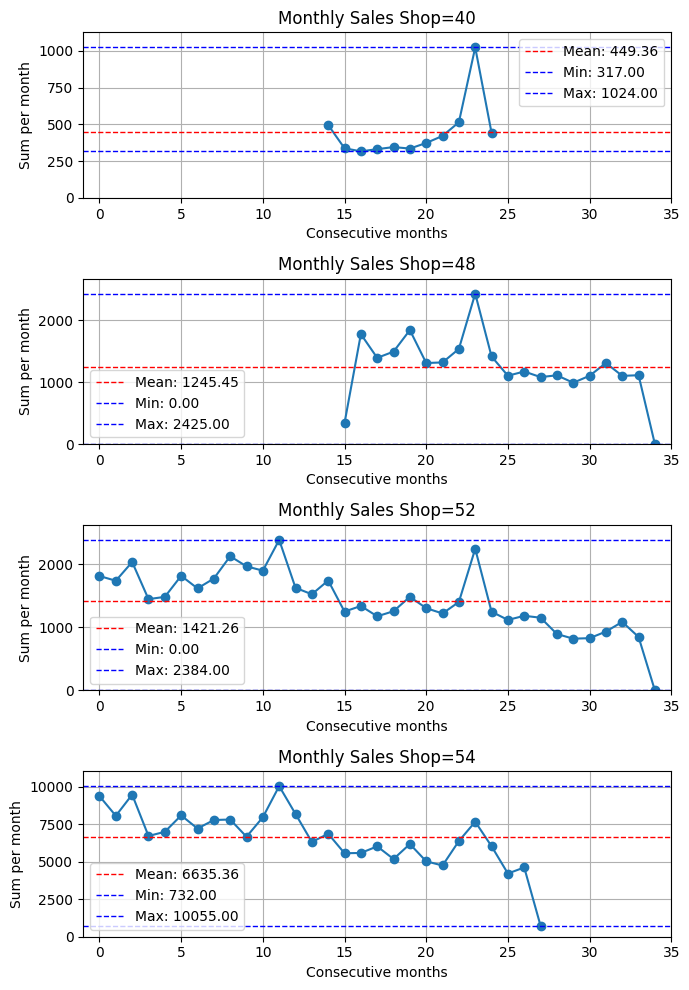

In [78]:
shops = [40, 48, 52, 54]

fig, ax = plt.subplots(4, 1, figsize=(7, 10))
for ix, i in enumerate(shops):
    ax[ix].plot(monthly_sales_per_shop_matrix[i], marker='o')
    ax[ix].axhline(np.nanmean(monthly_sales_per_shop_matrix[i]), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.nanmean(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[ix].axhline(np.nanmin(monthly_sales_per_shop_matrix[i]), color='blue', linestyle='dashed', linewidth=1, label=f'Min: {np.nanmin(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[ix].axhline(np.nanmax(monthly_sales_per_shop_matrix[i]), color='blue', linestyle='dashed', linewidth=1, label=f'Max: {np.nanmax(monthly_sales_per_shop_matrix[i]):.2f}')
    ax[ix].set_xlim(-1, 35)
    ax[ix].set_ylim(min(0, np.nanmin(monthly_sales_per_shop_matrix[i])), 1.1 * np.nanmax(monthly_sales_per_shop_matrix[i]))
    ax[ix].grid(True)
    ax[ix].set_title(f'Monthly Sales Shop={i}')
    ax[ix].set_xlabel('Consecutive months')
    ax[ix].set_ylabel('Sum per month')
    ax[ix].legend()

plt.tight_layout()
plt.show()
fig.savefig('assets/plots/shop_monthly_sales.png')

In [73]:
"""
Rozbiezność cen tego samego produktu w róznych sklepach.
Wartość przedstawia odsetek produktów dla których cena rózni sie
miedzy sklepami. 
Wniosek: nie mozemy zakladać ze jeśli produkt był sprzedany w jednym sklepie 
po danej cenie, to w innym sklepie będzie sprzedawany po tej samej.
Musimy przyjąć jakąś metodę szacowania ceny. Jest to równiez 
miejsce na potencjalą inzynierie cech
"""
(df[['item_id', 'item_price']].groupby("item_id")['item_price'].nunique().values > 1).mean() # type: ignore

np.float64(0.7163283716734326)

In [74]:
"""
Rozbiezność cen tego samego produktu w tym samym sklepie.
Innymi słowy zmienność ceny produktu.
Wartość przedstawia odsetek produktów dla ktorych tena rózni
się w tym samym sklepie (na przestrzeni czasu).
"""
(df[['shop_id', 'item_id', 'item_price']].groupby(['shop_id', "item_id"])['item_price'].nunique().values > 1).mean() # type: ignore

np.float64(0.27958703408487057)

## x. **Rózne testy**

Date_block_num: 1
	Column: shop_id 
	Diff: [5] (size 1)

	Column: item_id 
	Diff: [   12    30    31 ... 22138 22150 22157] (size 1237)

	Column: item_category_id 
	Diff: [48] (size 1)

Date_block_num: 2
	Column: shop_id 
	Diff: [57 58] (size 2)

	Column: item_id 
	Diff: [   37    68   100   378   485   552   562   608   793   901  1123  1127
  1138  1196  1215  1251  1255  1262  1275  1278  1335  1338  1395  1411
  1459  1460  1461  1462  1473  1612  1640  1672  1680  1719  1735  1744
  1756  1757  1770  1778  1779  1834  1939  1940  1941  1942  1943  1944
  1945  1955  1983  2056  2061  2074  2076  2079  2098  2148  2154  2165
  2169  2172  2193  2207  2250  2260  2315  2316  2344  2345  2393  2402
  2436  2491  2584  2605  2606  2612  2617  2622  2676  2759  2807  2919
  2959  2962  2981  3053  3074  3102  3118  3151  3173  3299  3404  3494
  3511  3549  3575  3585  3588  3655  3673  3689  3690  3695  3696  3697
  3738  3739  3765  3796  3800  3813  3825  3828  3829  3906  3911  395

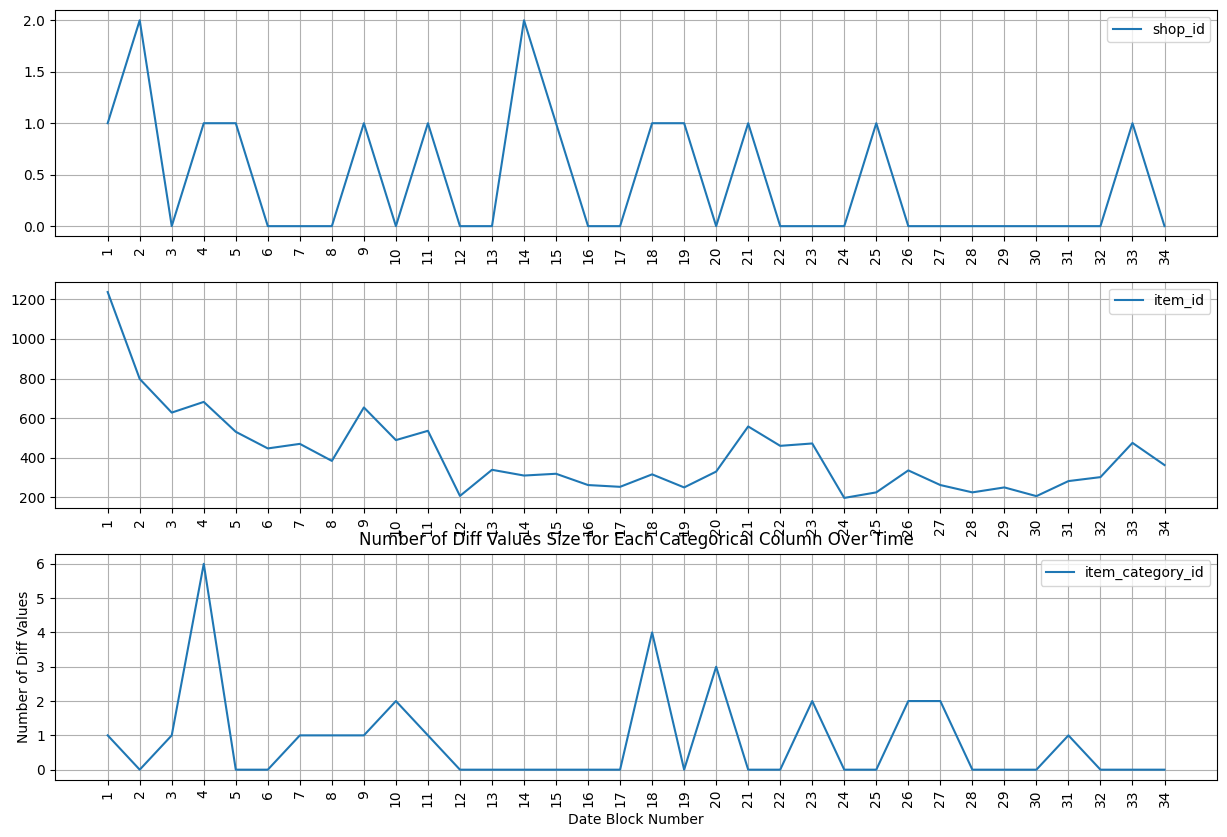

In [75]:
"""
Liczba nowych wartości dodawanych do zbioru danych na przestrzeni czasu. 
Z (prawie) kazdym miesiącem przybywa sklepów, produktów i kategorii.

Wniosek: nalezy stworzyć metodę przetwarzania dla nowych wartości.
"""

cat_columns = ['shop_id', 'item_id', 'item_category_id']
date_blocks_num = sorted(list(df['date_block_num'].unique()))[1:]

diff_sizes = {col: [] for col in cat_columns}

for date in date_blocks_num:
    df_date_train = df[df['date_block_num'] < date]
    df_date_valid = df[df['date_block_num'] == date]

    print(f"Date_block_num: {date}")

    for column in cat_columns:
        train_uq = df_date_train[column].unique()
        valid_uq = df_date_valid[column].unique()
        diff = np.setdiff1d(valid_uq, train_uq)
        diff_sizes[column].append(diff.size)
        print(f"\tColumn: {column} \n\tDiff: {diff} (size {diff.size})\n")

# Plotting the diff sizes for each categorical column
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

for i, column in enumerate(cat_columns):
    ax[i].plot(date_blocks_num, diff_sizes[column], label=column)
    ax[i].legend()
    ax[i].grid(True)
    ax[i].set_xticks(date_blocks_num)  # Set ticks to 1
    ax[i].set_xticklabels(date_blocks_num, rotation=90)  # Rotate labels for better readability
    
plt.xlabel('Date Block Number')
plt.ylabel('Number of Diff Values')
plt.title('Number of Diff Values Size for Each Categorical Column Over Time')
plt.show()
